Autor: Vladimir Indjic, SW 4/2014

# Citanje teksta napisanog u vise redova

## 1. Priprema

### Neophodne biblioteke

In [1]:
from __future__ import print_function
#import potrebnih biblioteka
import cv2
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

#Sklearn biblioteka sa implementiranim K-means algoritmom
from sklearn import datasets
from sklearn.cluster import KMeans

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 16, 12

Using Theano backend.


### Funkcije za rad sa slikom

In [2]:
#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

### Funkcije koje olaksavaju rad sa neuronskom mrezom

In [3]:
#Funkcionalnost implementirana u OCR basic
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

### Manipulacija regionima

In [4]:
def select_roi(image_orig, image_bin):
    """
        Funkcija zaduzena za izdvajanje regiona i njihovo iscrtavanje na slici
    """
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #Način određivanja kontura je promenjen na spoljašnje konture: cv2.RETR_EXTERNAL
    regions_array = []
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        region = image_bin[y:y+h+1,x:x+w+1];
        regions_array.append([resize_region(region), (x,y,w,h)])
        cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    return image_orig, regions_array
    
def sort_x_axis(regions_array):    
    """
        Funkcija zaduzena za sortiranje regiona po x osi i 
        odredjivanje distance po istoj za svaki par susednih regiona. 
    """
    regions_array = sorted(regions_array, key=lambda item: item[1][0])
    sorted_regions = [region[0] for region in regions_array]
    sorted_rectangles = [region[1] for region in regions_array]
    region_distances = []
    # Izdvojiti sortirane parametre opisujućih pravougaonika
    # Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
    for index in range(0, len(sorted_rectangles)-1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index+1]
        distance = next_rect[0] - (current[0]+current[2]) #X_next - (X_current + W_current)
        region_distances.append(distance)

    return regions_array, sorted_regions, region_distances

def sort_y_axis(regions_array):    
    """
        Funkcija zaduzena za sortiranje regiona po y osi i 
        odredjivanje distance po istoj za svaki par susednih regiona. 
    """
    regions_array = sorted(regions_array, key=lambda item: item[1][1])
    sorted_regions = [region[0] for region in regions_array]
    sorted_rectangles = [region[1] for region in regions_array]
    region_distances = []
    # Izdvojiti sortirane parametre opisujućih pravougaonika
    # Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
    for index in range(0, len(sorted_rectangles)-1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index+1]
        distance = abs(next_rect[1] - current[1]) # oduzimamo vrhove
        region_distances.append(distance)

    return regions_array, sorted_regions, region_distances

### Kreiranje i treniranje neuronske mreze

In [5]:
def create_ann(alphabet):
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(len(alphabet), activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, epochs=500, batch_size=1, verbose = 0, shuffle=False) 
      
    return ann

### K-Means algoritam, gde je k = 2

In [6]:
def apply_k_means(distances):
    """
        Funkcija koja trenira K-Means objekat i vraca ga.
    """
    #Podešavanje centara grupa K-means algoritmom
    distances = np.array(distances).reshape(len(distances), 1)
    #Neophodno je da u K-means algoritam bude prosleđena matrica u kojoj vrste određuju elemente
    k_means = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
    k_means.fit(distances)
    return k_means

### Podela karaktera u redove primenom K-Means algoritma

In [7]:
def separate_in_rows(characters_regions):
    """
        Podela prepoznatih regiona sa slovima na redove.
    """
    # sortiranje po y-osi
    character_regions, regions, distances = sort_y_axis(characters_regions)
    # primena K-Means algoritm
    k_means = apply_k_means(distances)
    
    rows = [[]] # pretpostavka da ima bar jedan red
    current_index = 0 # trenutni red indeksa
    # oznaka novog reda
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]    
    rows[0].append(character_regions[0]) # prvo slovo u prvi red
    for idx, letter in enumerate(character_regions[1:]):
        # kreiranje novog reda
        if (k_means.labels_[idx] == w_space_group):
            current_index += 1
            rows.append([])
        # dodavanje regiona sa karakterom u odgovarajuci red    
        rows[current_index].append(letter)
    # vracamo regione karaktere podeljene u redove
    return rows

### Podela karaktera u reci primenom K-Means algoritma

In [8]:
def print_row(row, ann):
    """
        Funkcija koja stampa jedan red teksta.
    """
    # soriranje po x-osi
    character_regions, regions, distances = sort_x_axis(row)
    # priprema za neuronsku mrezu
    inputs = prepare_for_ann(regions)
    # predikcija karaktera na osnovu sadrzaja regiona
    outputs = ann.predict(np.array(inputs, np.float32))
    
    # primenjujemo k_means algoritam
    k_means = apply_k_means(distances)
    
    # oznaka razmaka izmedju reci
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]    
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Da li treba da se doda razmak
        if (k_means.labels_[idx] == w_space_group):
            result += ' '
        # dodavanje odgovarajuceg slova u tekst
        result += alphabet[winner(output)]
    return result

## 2. Zadatak

### Priprema i treniranje neuronske mreze

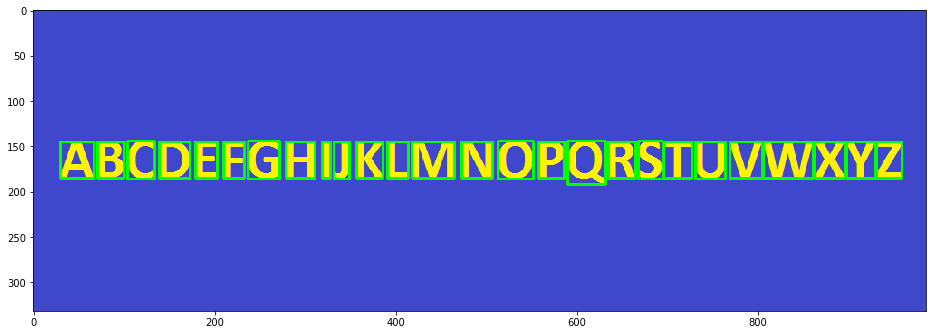

In [9]:
# Ucitavanje i binarizacija slike alfabeta kalkulatora
img_color = load_image('alphabet.png')
img_bin = image_bin(image_gray(img_color))

# Izdvajanje regiona sa karakterima alfabeta
img_selected_regions, characters_regions = select_roi(img_color, img_bin)
characters_regions, regions, _ = sort_x_axis(characters_regions) 
display_image(img_selected_regions, True)

# Unosimo alfabet i pripremamo ga za neuronsku mrezu 
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
outputs = convert_output(alphabet)

# Priprema izdvojenih region sa karakterima
inputs = prepare_for_ann([region for region in regions])

# kreiranje neuronske mreze
ann = create_ann(alphabet)
# treniranje neuronske mreze
ann = train_ann(ann, inputs, outputs)

### Izdvajanje regiona sa slovima iz teksta

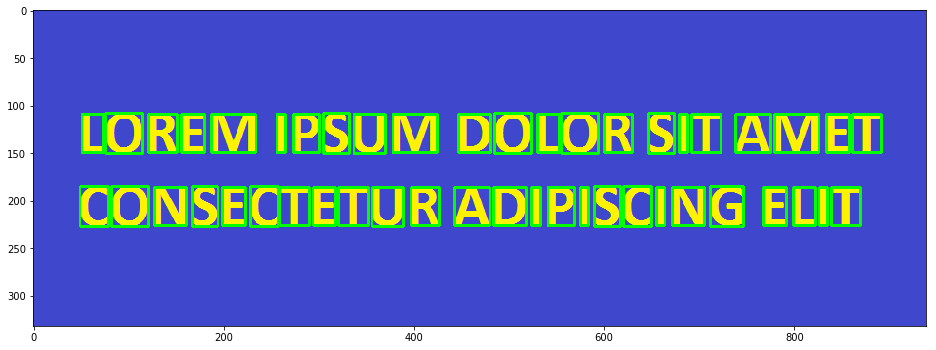

In [10]:
# Ucitavanje i binarizacija slike sa tekstom
img_color = load_image('Dodatni.png')
img_bin = image_bin(image_gray(img_color))

# Izdvajanje regiona sa slovima
img_selected_regions, characters_regions = select_roi(img_color, img_bin)
display_image(img_selected_regions, True)


### Odredjivanje redova

In [11]:
rows = separate_in_rows(characters_regions)

print("Broj prepoznatih redova je: %d." % (len(rows)))

Broj prepoznatih redova je: 2.


### Odredjivanje reci u redu

In [12]:
for row in rows: 
    print(print_row(row, ann))

LOREM IPSUM DOLOR SIT AMET
CONSECTETUR ADIPISCING ELIT
